In [11]:
import json, nltk
from pathlib import Path
from nltk.corpus import stopwords
from typing import TypedDict
import pandas as pd
from IPython.display import display


class CutData(TypedDict):
    '''type of the cuts json data file'''
    label: str
    start: float
    end: float
    video: str

def clean_word(word: str, chars: list[str], rep: str = '') -> str:
    for c in chars:
        word = word.replace(c,rep)
    return word

inv_chars = ['\n', ',', '.', '"', '-', '?', '!', '¿', '¡', '_']

# cuts data contains list of data for each cut json file
cuts_data: list[CutData] = []
# words contain list of words for each cut, excepting stopwords
words: dict[str, list[str]] = {}
# times contain lenght (s) for each cut
times: dict[str, float] = {}
# videos contains videos names
videos: set[str] = set()

# If not downloaded, run
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

path = Path("../data/cuts/")
cuts = path.glob('**/*[!_signer][!_ap].json')

for idx, cut in enumerate(cuts):
    with cut.open() as datafile:
        data: CutData = json.load(datafile)
    cuts_data.append(data)
    words[cut] = [w for w in clean_word(data['label'], inv_chars, '').lower().split(' ') if (w and w not in stop_words)]
    times[cut] = (data['end'] - data['start'])
    videos.add(data['video'])

print(f'''La base de datos contiene:
    {len(videos)} videos completos
    {len(cuts_data)} clips resultantes de dividir los videos de acuerdo a los subtítulos
    {sum(times.values())} segundos de video''')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pdalbianco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La base de datos contiene:
    58 videos completos
    13397 clips resultantes de dividir los videos de acuerdo a los subtítulos
    70455.81500000032 segundos de video


Estadísticas de la duración de los clips:

count    13397.000000
mean         5.259074
std          2.715355
min          0.450000
25%          3.337000
50%          4.670000
75%          6.510000
max         25.580000
dtype: float64

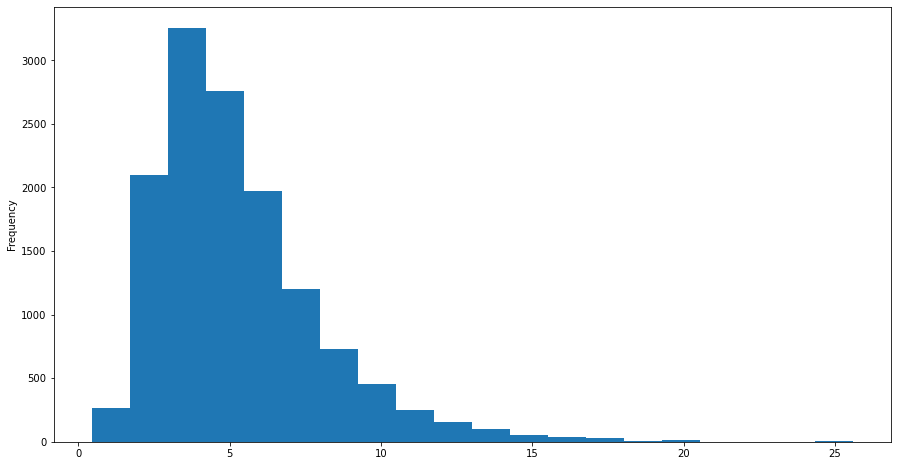

In [10]:
times_s = pd.Series(times)
display(times_s.describe())
out = times_s.plot.hist(bins=20,figsize=(15,8))

Estadísticas de cantidad de palabras por clip:

count    13975.000000
mean         4.752200
std          1.796361
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         12.000000
dtype: float64

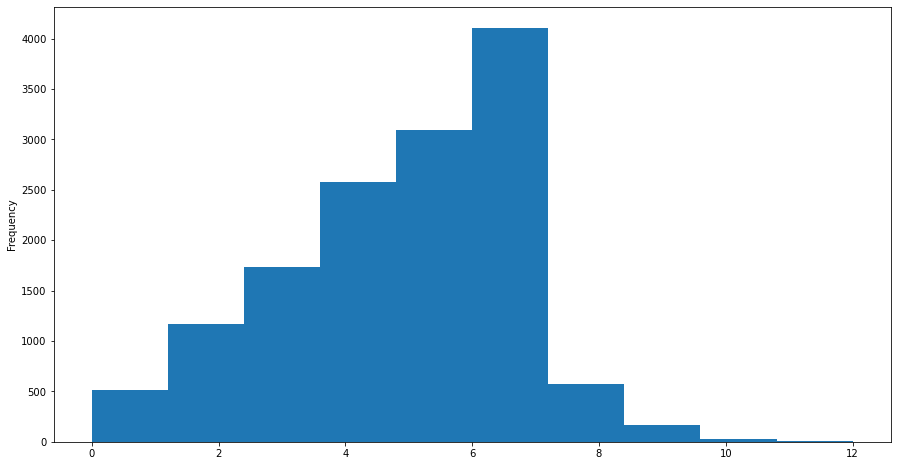

In [4]:
words_s = pd.Series({k: len(v) for k, v in words.items()})
display(words_s.describe())
out = words_s.plot.hist(figsize=(15,8))

Estadísticas acerca de frecuencia de palabras entre todos los clips:

count    13451.000000
mean         4.937328
std         15.692382
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        570.000000
dtype: float64

<AxesSubplot:>

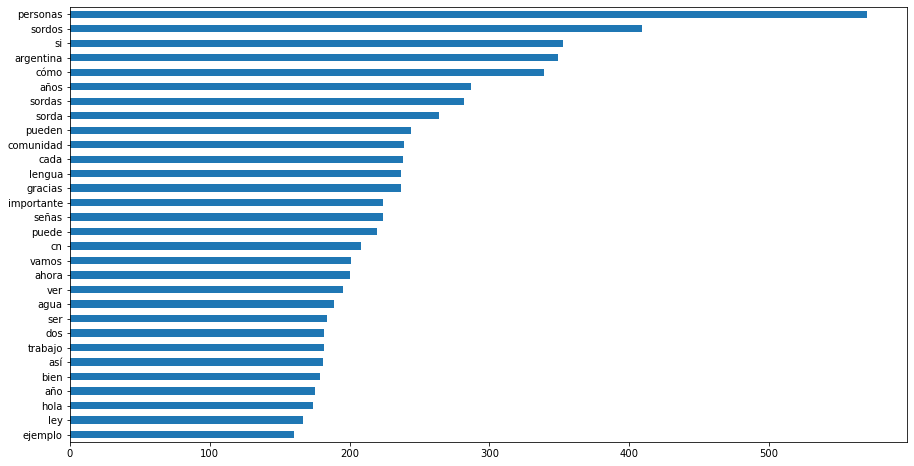

In [5]:
from collections import Counter

total_words = [item for sublist in words.values() for item in sublist]
word_count = Counter(total_words)

total_words_s = pd.Series(word_count).sort_values(ascending=False)
display(total_words_s.describe())
display(total_words_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))

count    55714.000000
mean         1.192016
std          2.051916
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        244.000000
dtype: float64

<AxesSubplot:>

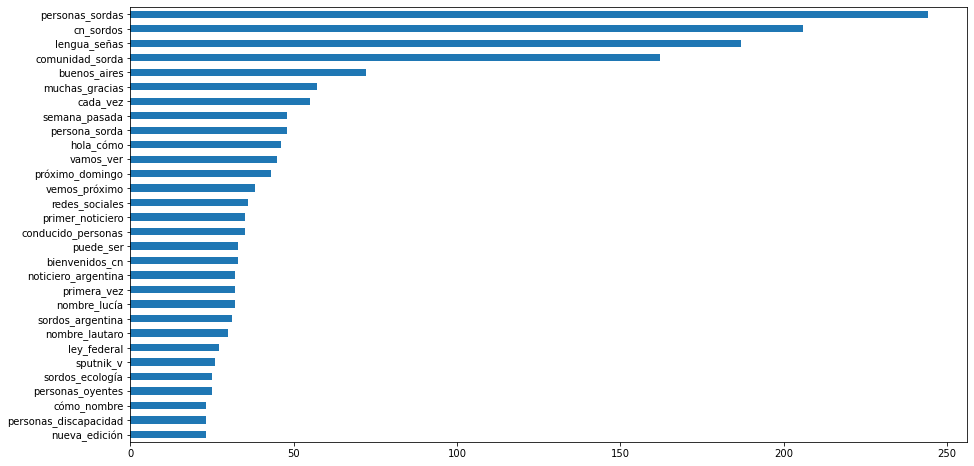

In [6]:
total_bigrams = ['_'.join(total_words[i:i + 2]) for i in range(len(total_words))]
bigram_count = Counter(total_bigrams)

total_bigrams_s = pd.Series(bigram_count).sort_values(ascending=False)
display(total_bigrams_s.describe())
display(total_bigrams_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))

count    63509.000000
mean         1.045710
std          0.484507
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         35.000000
dtype: float64

<AxesSubplot:>

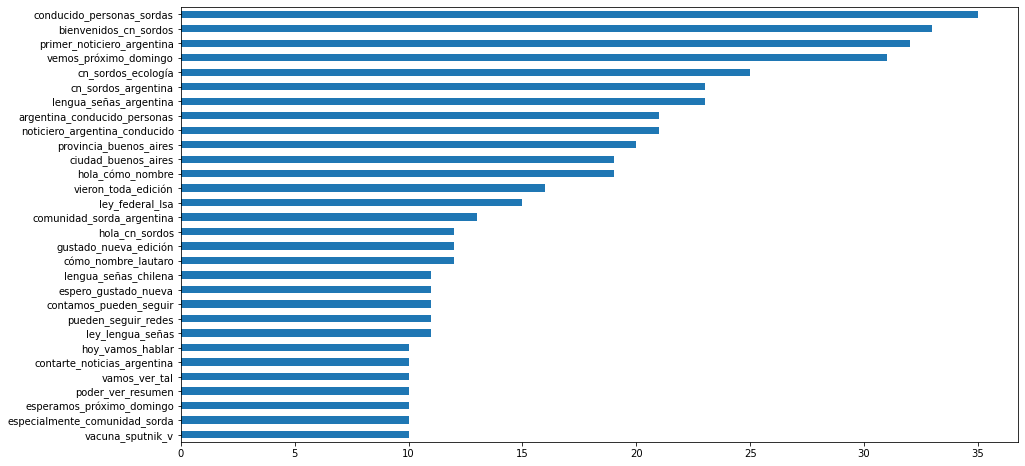

In [7]:
total_trigrams = ['_'.join(total_words[i:i + 3]) for i in range(len(total_words))]
trigram_count = Counter(total_trigrams)

total_trigrams_s = pd.Series(trigram_count).sort_values(ascending=False)
display(total_trigrams_s.describe())
display(total_trigrams_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))

Estadísticas acerca de las playlist a los que pertenecen los videos

res_semanal    44
ult_momento     2
ecologia        9
otros           3
dtype: int64


count     4.000000
mean     14.500000
std      19.908122
min       2.000000
25%       2.750000
50%       6.000000
75%      17.750000
max      44.000000
dtype: float64

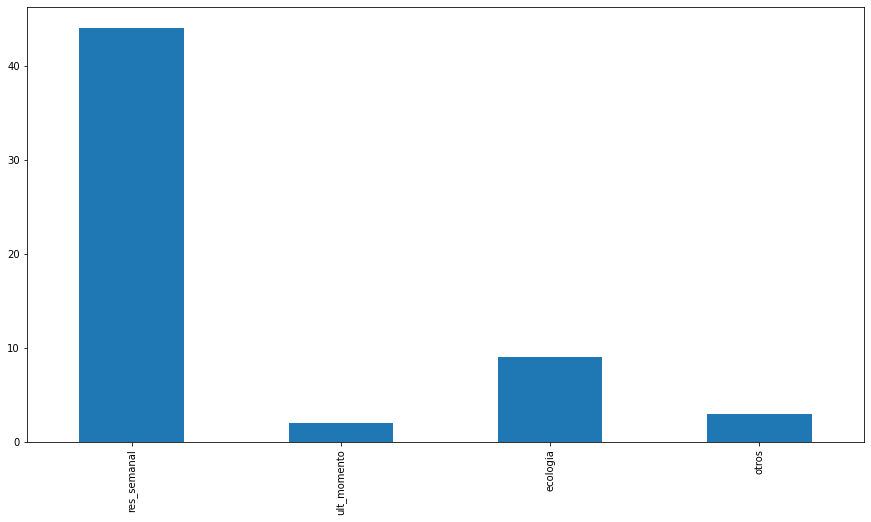

In [17]:
playlists = {
    'res_semanal': {v for v in videos if "resumen-semanal" in v},
    'ult_momento': {v for v in videos if "ultimo-momento" in v},
    'ecologia': {v for v in videos if "episodio" in v},
    'otros': {v for v in videos if ("resumen-semanal" not in v and "ultimo-momento" not in v and "episodio" not in v)},
}

playlist_s = pd.Series({p:len(vids) for p, vids in playlists.items()})
print(playlist_s)
display(playlist_s.describe())
out = playlist_s.plot.bar(figsize=(15,8))
